In [1]:
# Add the genderComputer library to the path
import os
import pandas as pd
import sys

path = os.path.join(os.getcwd(), 'vendor', 'genderComputer')
sys.path.insert(0, path)

In [2]:
# Infer the gender of the authors
import analyze_genders

df = analyze_genders.dataframe(field='DB')
aggregates = analyze_genders.aggregate_authorship(df)

In [3]:
df.drop_duplicates(subset=['paper_id']).groupby(['conf']).agg({'year': ['min', 'max', 'count'], 'author_id': pd.Series.nunique})

year             author_id
         min   max count   nunique
conf                              
CIDR    2003  2019   427       333
DASFAA  2001  2019  1457      1267
DKE     1985  2020  1719      1400
EDBT    1988  2020  1575      1284
ICDE    1984  2020  4764      3344
PODS    1982  2020  1256       636
SIGMOD  1975  2020  4111      2708
VLDB    1975  2020  5226      3424
VLDBJ   1992  2020   892       753

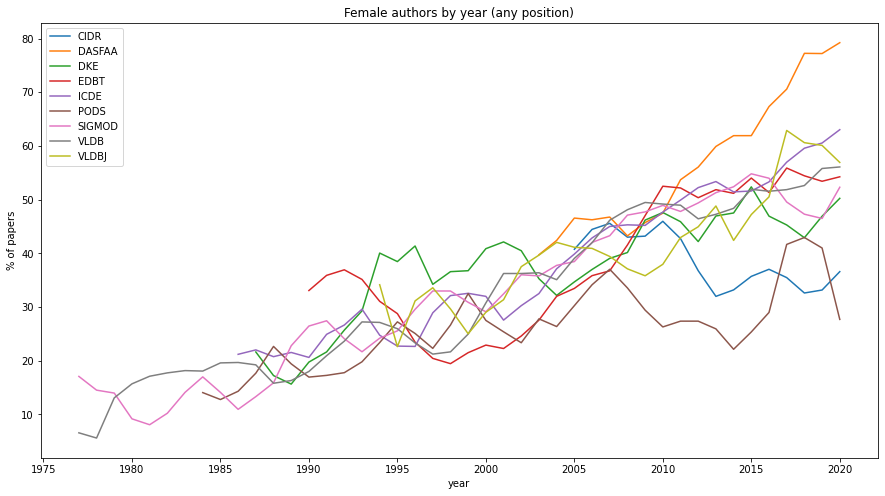

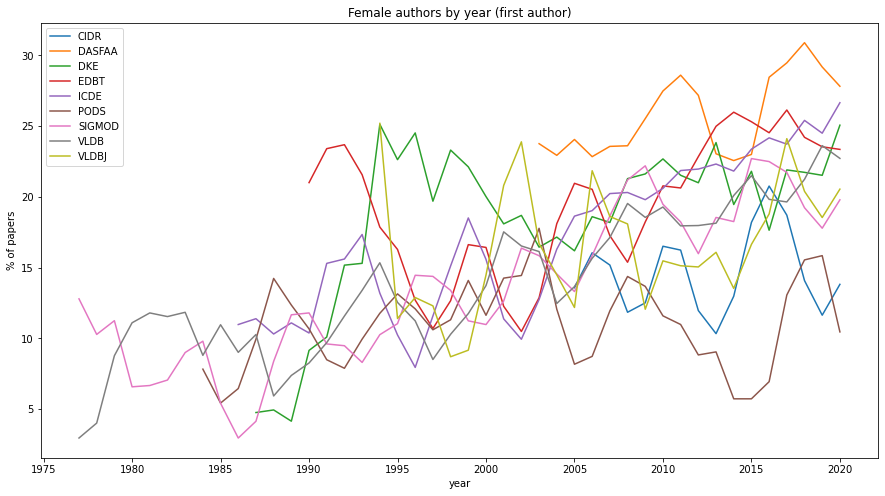

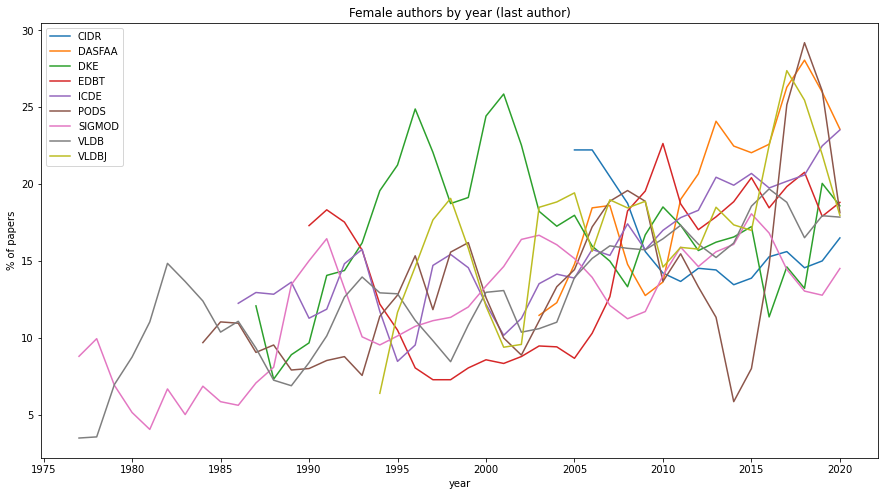

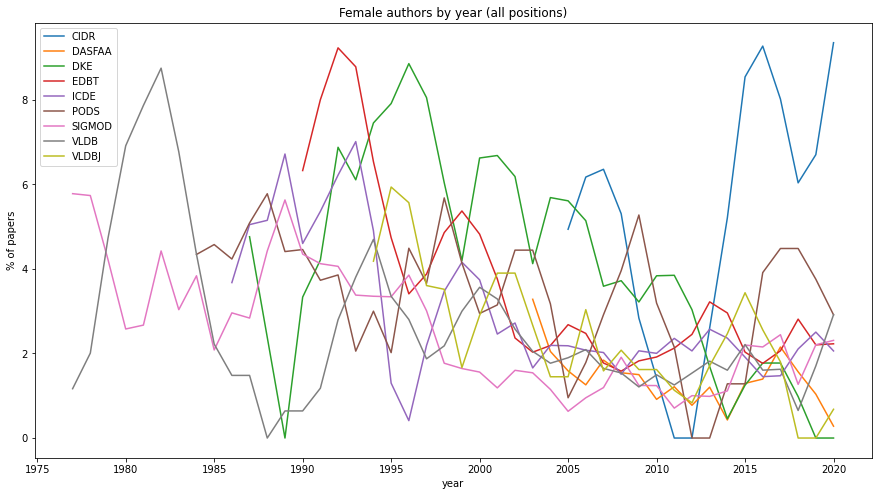

In [4]:
analyze_genders.plot_authors(aggregates['any'], 'any position')
analyze_genders.plot_authors(aggregates['first'], 'first author')
analyze_genders.plot_authors(aggregates['last'], 'last author')
analyze_genders.plot_authors(aggregates['all'], 'all positions')